# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**
- *Price* — цена (евро)

In [1]:
pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 80 kB 2.0 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import MEstimateEncoder

from lightgbm import LGBMRegressor

from time import time

import matplotlib.pyplot as plt
import seaborn as sns

## 1 Подготовка данных

Загрузим данные и посмотрим на них.

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


В данных есть пропущенные значения. 

Все числовые признаки, включая год и месяц, загрузились как int, даты и категориальные - как object.

In [4]:
df.sample(10, random_state=42)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
294049,2016-03-20 20:54:33,19999,wagon,2014,manual,122,leon,30000,3,petrol,seat,no,2016-03-20 00:00:00,0,22089,2016-03-27 10:47:13
76415,2016-03-25 12:56:02,14250,wagon,2011,manual,140,a3,70000,6,gasoline,audi,NaN,2016-03-25 00:00:00,0,45770,2016-03-29 11:48:26
212563,2016-03-09 13:46:02,2850,wagon,2001,manual,131,passat,150000,9,gasoline,volkswagen,no,2016-03-09 00:00:00,0,38259,2016-03-12 11:16:57
109307,2016-03-30 11:39:47,50,small,1996,manual,60,corsa,150000,8,petrol,opel,yes,2016-03-30 00:00:00,0,7957,2016-04-03 00:46:29
248545,2016-03-28 23:37:54,500,NaN,2016,manual,82,a_klasse,150000,2,petrol,mercedes_benz,NaN,2016-03-28 00:00:00,0,49356,2016-03-30 23:17:28
318907,2016-03-31 13:51:44,3000,convertible,2005,NaN,0,3_reihe,150000,0,petrol,peugeot,no,2016-03-31 00:00:00,0,53340,2016-04-06 06:44:47
227367,2016-03-19 20:50:32,1099,sedan,1983,auto,122,other,150000,3,petrol,mercedes_benz,no,2016-03-19 00:00:00,0,49779,2016-04-07 09:17:08
47677,2016-03-10 00:36:53,850,NaN,2016,manual,55,astra,150000,12,petrol,opel,no,2016-03-10 00:00:00,0,14656,2016-03-10 08:45:41
337147,2016-03-20 19:48:40,7999,small,2011,manual,99,500,90000,5,petrol,fiat,no,2016-03-20 00:00:00,0,71272,2016-04-07 04:16:53
164456,2016-03-20 09:46:40,5900,convertible,1977,NaN,0,NaN,100000,7,NaN,sonstige_autos,no,2016-03-20 00:00:00,0,32339,2016-04-06 05:16:17


Пробег указан в виде круглых чисел. Возможно, при заполнении анкеты значения были выбраны из предложенных. Тогда вариантов значений может быть немного. Это своего рода категориальные данные, но порядок значений тоже несёт в себе смысл.

Проверим, есть ли дубликаты.

In [5]:
df.duplicated().sum()

4

Удалим повторяющиеся строки.

In [6]:
df = df.drop_duplicates().reset_index(drop=True)

Посмотрим внимательнее, в каких столбцах есть пропуски и сколь их.

In [7]:
df.isna().sum().sort_values(ascending=False).head(6)

NotRepaired    71154
VehicleType    37490
FuelType       32895
Gearbox        19833
Model          19705
LastSeen           0
dtype: int64

Пропусков достаточно много, и всё это категориальные признаки автомобиля, которые сложно будет восстановить. Заполним эти пропуски словом 'none' - так мы сохраним информацию о том, что какие-то параметры в анкете не были указаны.

In [8]:
df = df.fillna('none')

Посмотрим на значения категориальных признаков и на общее количество вариантов значений. В том числе рассмотрим и значения столбцов Kilometer и NumberOfPictures, которые по смыслу притендуют на категориальность, а также PostalCode, чтобы оценить количество разных регионов в данных.

In [9]:
cat_features = [cname for cname in df.columns 
                if df[cname].dtype == 'object' 
                and 'Date' not in cname 
                and 'Seen' not in cname]

cat_features_ext = cat_features.copy()
cat_features_ext.extend(['Kilometer', 'NumberOfPictures', 'PostalCode'])

for col in cat_features_ext:
    print('{}: {}'.format(col, df[col].unique()))
    print('Уникальных значений: {}'.format(df[col].nunique()))
    print()

VehicleType: ['none' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальных значений: 9

Gearbox: ['manual' 'auto' 'none']
Уникальных значений: 3

Model: ['golf' 'none' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'ma

Количество фотографий всегда 0 - этот признак не несёт никакой ценной информации.

Вариантов значений пробега всего 13. Оставим этот признак числовым, но выразим не в км, а в тыс.км. Другие категориальные признаки переведём в тип category.

В данных есть 8143 различных варианта значения индекса - это не очень много для более чем 350 тыс. объектов. Скорее всего, география объявления влияет на цену. Закодируем индексы по стоимости машин. Чтобы избежать утечки данных и переобучения, кодировать будем на основе 20% обучающей выборки. Создадим класс, чтобы использовать его в дальнейшем при кросс-валидации.

In [10]:
df = df.drop('NumberOfPictures', axis=1)
df['Kilometer'] /= 1000
df[cat_features] = df[cat_features].astype('category')

In [11]:
class PriceEncoder():
    '''Кодирует почтовый индекс по значениям стоимости машин в случайной подвыборке обучающей выборки.'''
    
    def fit(self, X, y):
        X_encode = X.sample(frac=0.2, random_state=42)
        y_encode = y[X_encode.index]
        
        self.encoder = MEstimateEncoder(cols=['PostalCode'], m=4)
        self.encoder.fit(X_encode, y_encode)
        return self
    
    def transform(self, X):
        return self.encoder.transform(X)

Создадим столбец с ориентировочным возрастом машины. 

На первом шаге запишем год создания анкеты и посмотрим, что ошибок в значениях нет.

In [12]:
df['YearOld'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d')
df['YearOld'] = df['YearOld'].apply(lambda x: x.year)

df['YearOld'].unique()

array([2016, 2015, 2014])

Посчитаем возраст с точностью до года.

In [13]:
df['YearOld'] -= df['RegistrationYear']
df['YearOld'].describe()

count    354365.000000
mean         11.765442
std          90.228466
min       -7983.000000
25%           8.000000
50%          13.000000
75%          17.000000
max        1016.000000
Name: YearOld, dtype: float64

Возраст оказался в широком диапазоне от -7983 до 1016 лет. Посмотрим на значения года регистрации автомобиля.

In [14]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Среди значений много явно ошибочных. Возможно, люди вводили заведомо неправильное значение, если не знали настоящее. Будем считать, что если возраст не укладывается в рамки от 0 до 100 лет, то у нас нет данных о возрасте. Обозначим такой вариант значением -10.

In [15]:
df.loc[(df['YearOld'] < 0) | (df['YearOld'] > 100),'YearOld'] = -10
df['YearOld'].describe()

count    354365.000000
mean         12.515635
std           8.227467
min         -10.000000
25%           8.000000
50%          13.000000
75%          17.000000
max          97.000000
Name: YearOld, dtype: float64

Другая информация из дат не представляет ценности для прогнозирования стоимости.

In [16]:
df = df.drop(['DateCrawled','RegistrationYear','RegistrationMonth','DateCreated','LastSeen'], axis=1)

Посмотрим на значения мощности.

In [17]:
df[['Power']].describe()

,Power
count,354365.000000
mean,110.093816
std,189.851330
min,0.000000
25%,69.000000
50%,105.000000
75%,143.000000
max,20000.000000


Среди значений есть очень большие. Посмотрим на распределение.

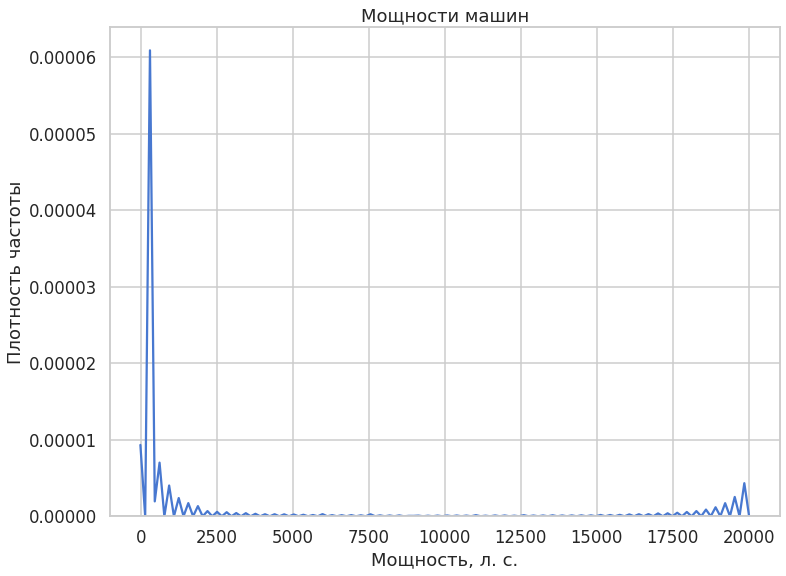

In [18]:
sns.set(context='talk', style='whitegrid', palette='muted')
plt.figure(figsize=(12, 9))

sns.distplot(
    df['Power'],
    kde=True,
    hist=False,
)

plt.title('Мощности машин')
plt.xlabel('Мощность, л. с.')
plt.ylabel('Плотность частоты')
plt.show()

Существуют машины с мощными двигателями, но не 20000 л.с. Посмотрим для ориентира на несколько машин с большим, но реалистичным значением л.с.

In [19]:
df[df['Power'] == 1800]

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode,YearOld
34332,450,none,none,1800,none,5.0,none,mitsubishi,no,63322,-10
65138,1450,small,auto,1800,vectra,150.0,petrol,opel,no,6112,16
139360,450,none,none,1800,none,5.0,none,mitsubishi,no,63322,-10
191184,1450,sedan,auto,1800,vectra,5.0,petrol,opel,no,6112,16
234097,1290,sedan,auto,1800,toledo,150.0,petrol,seat,no,13581,16
241039,1450,sedan,auto,1800,vectra,150.0,petrol,opel,no,6112,16
247154,2500,bus,manual,1800,zafira,150.0,none,opel,none,22941,15
296683,3500,wagon,manual,1800,none,150.0,gasoline,audi,no,83536,14


Это не Бугатти. В данных явно ошибка. Может быть, ошиблись в 10 раз? Но среди значений есть и ещё более увеличенные, и неестественно маленькие. Заменим все ошибочные данные на -10 и будем считать это поле незаполненным.

In [20]:
df.loc[(df['Power'] > 300) | (df['Power'] < 30),'Power'] = -10
df['Power'].describe()

count    354365.000000
mean        102.001044
std          62.229839
min         -10.000000
25%          66.000000
50%         102.000000
75%         140.000000
max         300.000000
Name: Power, dtype: float64

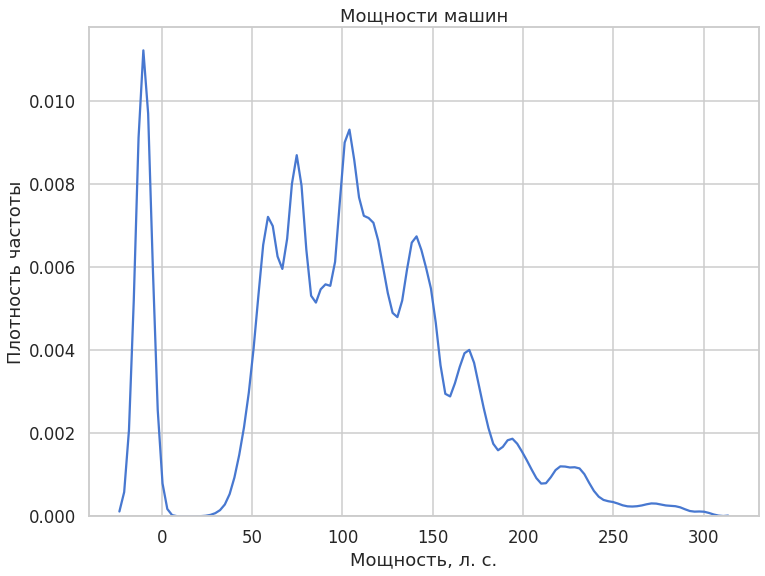

In [21]:
plt.figure(figsize=(12, 9))

sns.distplot(
    df['Power'],
    kde=True,
    hist=False,
)

plt.title('Мощности машин')
plt.xlabel('Мощность, л. с.')
plt.ylabel('Плотность частоты')
plt.show()

У нас есть десять признаков для прогнозирования стоимости. Если значения половины из них отсутствуют, то такой объект даёт больше шума, чем данных. Один из десяти признаков - это почтовый индекс, а не характеристика автомобиля. Удалим из таблицы объекты, у которых четыре и более признаков равно 'none' или -10.

In [22]:
# Жалуется, что приходится сравнивать с 'none', но сравнивает.
import warnings
warnings.filterwarnings("ignore")

df = df.drop(df[((df == 'none') | (df == -10)).sum(axis=1) >= 4].index, axis=0).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338708 entries, 0 to 338707
Data columns (total 11 columns):
Price          338708 non-null int64
VehicleType    338708 non-null category
Gearbox        338708 non-null category
Power          338708 non-null int64
Model          338708 non-null category
Kilometer      338708 non-null float64
FuelType       338708 non-null category
Brand          338708 non-null category
NotRepaired    338708 non-null category
PostalCode     338708 non-null int64
YearOld        338708 non-null int64
dtypes: category(6), float64(1), int64(4)
memory usage: 15.2 MB


Создадим отдельные переменные для признаков и для целевого признака. Кроме того, сохраним список имён числовых признаков. Список имён категориальных признаков у нас уже есть - cat_features.

In [23]:
X = df.drop('Price', axis=1)
y = df['Price']

num_features = [cname for cname in X.columns if X[cname].dtype in ['int','float']]

del(df)

### Вывод

Данные загружены и изучены. Дубликаты удалены, пропуски заполнены, типы данных преобразованы. Создан столбец с возрастом машин. Для кодирования почтового индекса по средней стоимости машин создан класс.

Неестественные значения признаков приравнены к пропущенным. Удалены объекты, у котороых пропущенно четыре и более значений признаков.

Созданы таблицы X и y с признаками и целевым признаком. Сохранены списки имён категориальных и числовых признаков.

## 2 Обучение моделей

### 2.1 Dummy-модель

Для ориентира посмотрим значение RMSE для модели, которая всегда предсказывает среднее значение целевого признака обучающей выборки.

In [24]:
def score_dataset(model, X, y):
    '''Считает RMSE на кросс-валидации.'''
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    score = abs(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)) ** 0.5
    score = score.mean()
    return score

In [25]:
rmse_dm = score_dataset(DummyRegressor(strategy='mean'), X, y)
time_dm = '-'

print('Для dummy-модели RMSE = {:.0f}'.format(rmse_dm))

Для dummy-модели RMSE = 4539


**Вывод**

Создана функция для расчёта RMSE на кросс-валидации. Получено пороговое значение метрики для определения адекватности моделей.

### 2.2 Линейная регрессия

В поставленной задаче важна скорость обучения. Линейная регрессия работает быстрее деревянных моделей. Для успешности обучения необходимо преобразовать признаки: масштабировать численные и закодировать категориальные. 

Для всех моделей понадобится одинаковая цепочка действий: до обучения модели преобразовать индекс по части данных обучающей выборки. Для линейной регрессии потребуется ещё масштабирование численных признаков.

In [26]:
def get_pipline(model, num_transformer=False, num_features=num_features):
    '''Создаёт пайплайн: преобразование почтового индекса, модель. 
    Для num_transformer=True после преобразования индекса все числовые признаки масштабируются в [0,1].'''
    
    if num_transformer:
        preprocessor = ColumnTransformer(
            transformers = [('num', MinMaxScaler(), num_features)],
            remainder = 'passthrough',
            n_jobs = -1
        )
        pipeline = Pipeline(steps=[('post_price', PriceEncoder()),
                                   ('preprocessor', preprocessor),
                                   ('model', model)])
    else:
        pipeline = Pipeline(steps=[('post_price', PriceEncoder()),
                                   ('model', model)])
        
    return pipeline

Для категориальных признаков используем прямое кодирование.

In [27]:
%%time

X_lr = pd.get_dummies(X, drop_first=True)
model_lr = LinearRegression(n_jobs=-1)
pipeline_lr = get_pipline(model_lr, num_transformer=True)
rmse_lr = score_dataset(pipeline_lr, X_lr, y)

print('Для линейной регрессии RMSE = {:.0f}'.format(rmse_lr))
print()

Для линейной регрессии RMSE = 2814

CPU times: user 2min 7s, sys: 47.6 s, total: 2min 55s
Wall time: 2min 55s


Сохраним время обучения линейной регрессии.

In [28]:
def exec_time(start, end):
    '''Выдаёт время между start и end в виде строки "x мин. y сек.".'''
    
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    return '{:.0f} мин. {:.0f} сек.'.format(m, s)

In [29]:
def fitting(model, X, y):
    '''Возвращает обученную модель и время, которое ушло на обучение.'''
    
    start = time()
    model.fit(X, y)
    end = time()
    return model, exec_time(start, end)

In [30]:
pipeline_lr, time_lr = fitting(pipeline_lr, X_lr, y)
print('Время на обучение линейной регрессии:', time_lr)

Время на обучение линейной регрессии: 0 мин. 39 сек.


**Вывод**

Создана функция для получения цепочки из преобразования почтового индекса и модели.

Посчитано ориентировочное время на обучение линейной регресси с учётом преобразования признаков и RMSE на кросс-валидации.

### 2.3 Случайный лес

Для случайного леса используем порядковое кодирование категориальных признаков, чтобы не увеличивать их количество. Найдём оптимальные параметры модели.

In [31]:
def search_params(model, params, X, y):
    '''Ищет лучшие параметры модели с помощью GridSearch. Возвращает лучшие параметры и RMSE.'''
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    grid_search = GridSearchCV(
        model, params, 
        scoring = 'neg_mean_squared_error', 
        cv = kf,
        n_jobs = -1,
        refit = False
    )
    grid_search.fit(X, y)
    return grid_search.best_params_, abs(grid_search.best_score_) ** 0.5

In [32]:
model_rf = RandomForestRegressor(random_state=42)

params_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [20, 30]
}

pipeline_rf = get_pipline(model_rf)

In [33]:
%%time

encoder = OrdinalEncoder()
X_rf = X.copy()
X_rf[cat_features] = encoder.fit_transform(X_rf[cat_features])

best_params_rf, rmse_rf = search_params(pipeline_rf, params_rf, X_rf, y)

print('Лучшие параметры:', best_params_rf)
print('Для случайного леса RMSE = {:.0f}'.format(rmse_rf))
print()

Лучшие параметры: {'model__max_depth': 20, 'model__n_estimators': 200}
Для случайного леса RMSE = 1716

CPU times: user 1h 6min 31s, sys: 21.3 s, total: 1h 6min 52s
Wall time: 1h 7min 7s


Посмотрим, сколько времени занимает обучение лучшей модели.

In [34]:
model_rf = RandomForestRegressor(
    n_estimators = 200, 
    max_depth = 20, 
    random_state = 42
)

pipeline_rf = get_pipline(model_rf)

pipeline_rf, time_rf = fitting(pipeline_rf, X_rf, y)
print('Время на обучение случайного леса:', time_rf)

Время на обучение случайного леса: 4 мин. 52 сек.


**Вывод**

Для случайного леса выбраны лучшие гиперпараметры из четырёх вариантов. Посчитано значение RMSE и время обучения.

### 2.4 Градиентный бустинг

Подберём параметры для градиентного бустинга. LightGBM умеет работать с категориальными признаками, поэтому кодирование не понадобится.

In [35]:
model_gb = LGBMRegressor(random_state = 42)

params_gb = {
    'model__n_estimators': [100, 500],
    'model__max_depth': [10, 20]
}

pipeline_gb = get_pipline(model_gb)

In [36]:
%%time

best_params_gb, rmse_gb = search_params(pipeline_gb, params_gb, X, y)

print('Лучшие параметры:', best_params_gb)
print('Для градиентного бустинга RMSE = {:.0f}'.format(rmse_gb))
print()

Лучшие параметры: {'model__max_depth': 20, 'model__n_estimators': 500}
Для градиентного бустинга RMSE = 1688

CPU times: user 26min 13s, sys: 10.2 s, total: 26min 23s
Wall time: 26min 37s


Посмотрим, сколько времени занимает обучение лучшей модели.

In [38]:
model_gb = LGBMRegressor(
    n_estimators = 500, 
    max_depth = 20,  
    random_state = 42
)

pipeline_gb = get_pipline(model_gb)

pipeline_gb, time_gb = fitting(pipeline_gb, X, y)
print('Время на обучение градиентного бустинга:', time_gb)

Время на обучение градиентного бустинга: 2 мин. 59 сек.


**Вывод**

Для градиентного бустинга выбраны лучшие гиперпараметры из четырёх вариантов. Посчитано значение RMSE и время обучения.

### 2.5 Вывод

Рассмотрены три модели: линейная регрессия, случайный лес и градиентный бустинг. Для двух последних подобраны лучшие гиперпараметры из нескольких вариантов. 

Для каждой модели посчитанано значение RMSE на кросс-валидации и зафиксировано время, необходимое на обучение. Кроме того, метрика посчитана на dummy-модели.

Для линейной регрессии использовано прямое кодирование категориальных признаков и масштабирование численных. Для случайного леса - порядковое кодирование. И для всех моделей почтовый индекс был закодирован по средней стоимости машин.

Быстрее всего работает линейная ререссия. Лучшее значение метрики показал градиентный бустинг.

## 3 Анализ моделей

Рассмотрим результаты обучения моделей.

In [39]:
train_result = pd.DataFrame(
    {
        'DummyRegressor': [int(rmse_dm), time_dm],
        'LinearRegression': [int(rmse_lr), time_lr],
        'RandomForestRegressor': [int(rmse_rf), time_rf],
        'LGBMRegressor': [int(rmse_gb), time_gb],
    }, 
    index=['RMSE', 'Fitting time']
)
train_result

,DummyRegressor,LinearRegression,RandomForestRegressor,LGBMRegressor
RMSE,4539,2813,1715,1688
Fitting time,-,0 мин. 39 сек.,4 мин. 52 сек.,2 мин. 59 сек.


Посмотрим, сколько времени займёт предсказание для каждой модели.

In [40]:
def prediction_timing(model, X):
    '''Возвращает время, которое ушло на получение предсказаний.'''
    
    start = time()
    preds = model.predict(X)
    end = time()
    return exec_time(start, end)

In [41]:
train_result.loc['Prediction time','DummyRegressor'] = time_dm
train_result.loc['Prediction time','LinearRegression'] = prediction_timing(pipeline_lr, X_lr)
train_result.loc['Prediction time','RandomForestRegressor'] = prediction_timing(pipeline_rf, X_rf)
train_result.loc['Prediction time','LGBMRegressor'] = prediction_timing(pipeline_gb, X)

train_result

,DummyRegressor,LinearRegression,RandomForestRegressor,LGBMRegressor
RMSE,4539,2813,1715,1688
Fitting time,-,0 мин. 39 сек.,4 мин. 52 сек.,2 мин. 59 сек.
Prediction time,-,0 мин. 1 сек.,0 мин. 25 сек.,0 мин. 23 сек.


Показатели RMSE можно уменьшить и для случайного леса, и для градиентного бустинга, найдя оптимальные гиперпараметры. С учётом временных затрат на обучение лучше проводить такой поиск для градиентного бустинга.

### Вывод

Лучшее значение RMSE даёт модель градиентного бустинга, но при этом она тратит сопоставимое со случайным лесом время на расчёт предсказаний. Время обучения и время на поиск оптимальных гиперпараметров у леса значительно хуже, чем у бустинга. Линейная регрессия работает быстро, но не даёт достаточно точный прогноз.

## 4 Вывод

Данные загружены и подготовлены: удалены дубликаты, заполнены пропуски, преобразованы типы, сделаны расчёты. Объекты с большим количеством пропущенных значений признаков удалены из рассмотрения.

Изучены модели линейной регрессии, случайного леса и градиентного бустинга. Для последних двух рассмотрено по четыре варианта значений гиперпараметров. Для каждой модели посчитаны значения RMSE и времени, потраченного на обучение и на получение предсказаний.

Случайный лес по совокупности временных затрат проигрывает градиентному бустингу, значение RMSE также хуже. Линейная регрессия показала наилучшее время работы, но наименее точные предсказания. Оптимальной моделью для поставленной задачи является градиентный бустинг.

## 5 Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей